In [1]:
!pip install torch_geometric --quiet
!pip install nni --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 28.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 9.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64"

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import os
import json
from torch_geometric.utils import dense_to_sparse
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

import torch
import gc
from torch.utils.data import DataLoader
from collections import deque

# Custom imports
import sys
sys.path.insert(1, "../input/dependecies")

import GCN
from Graph import Graph
from data_generator import generate_arch_dicts

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TEST = False

In [3]:
model_diversity_path = "../input/weights/model_diversity_weights.pth"
model_accuracy_path = "../input/weights/model_accuracy_weights.pth"

In [4]:
input_dim = 8
output_dim = 128
dropout=0.1

model_diversity = GCN.GAT(input_dim, output_dim, dropout).to(device)
state_dict = torch.load(model_diversity_path, map_location=device, weights_only=True)
model_diversity.load_state_dict(state_dict)
model_diversity.eval()

GAT(
  (gat1): GATv2Conv(8, 16, heads=4)
  (gat2): GATv2Conv(64, 64, heads=4)
  (gat3): GATv2Conv(256, 64, heads=4)
  (gat4): GATv2Conv(256, 16, heads=4)
  (res1): Linear(in_features=8, out_features=64, bias=True)
  (res2): Linear(in_features=64, out_features=256, bias=True)
  (res3): Linear(in_features=256, out_features=256, bias=True)
  (res4): Linear(in_features=256, out_features=64, bias=True)
  (norm1): GraphNorm(64)
  (norm2): GraphNorm(256)
  (norm3): GraphNorm(256)
  (norm4): GraphNorm(64)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
)

In [5]:
input_dim = 8
output_dim = 1
dropout = 0.4
heads = 16

model_accuracy = GCN.GAT(input_dim, output_dim, dropout, heads=heads).to(device)
state_dict = torch.load(model_accuracy_path, map_location=device, weights_only=True)
model_accuracy.load_state_dict(state_dict)
model_accuracy.eval()

GAT(
  (gat1): GATv2Conv(8, 4, heads=16)
  (gat2): GATv2Conv(64, 16, heads=16)
  (gat3): GATv2Conv(256, 16, heads=16)
  (gat4): GATv2Conv(256, 4, heads=16)
  (res1): Linear(in_features=8, out_features=64, bias=True)
  (res2): Linear(in_features=64, out_features=256, bias=True)
  (res3): Linear(in_features=256, out_features=256, bias=True)
  (res4): Linear(in_features=256, out_features=64, bias=True)
  (norm1): GraphNorm(64)
  (norm2): GraphNorm(256)
  (norm3): GraphNorm(256)
  (norm4): GraphNorm(64)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

Зададим гиперпараметры:

1. K -- количество моделей в ансамбле
2. ALPHA -- трейд-off между точностью и разнообразием, где разнообразие определяется как расстояние эмбеддингов до ансамбля.
3. N -- количество моделей в одной эпохе

Мы хотим, чтобы в ансамбле были точные модели, поэтому введем $\gamma$ -- минимальную точность модели.

In [6]:
K = 6
N = 250_000
M = 16192
GAMMA = 0.871
BATCH_SIZE = 8192

In [7]:
def find_dist_to_best(best_embs, emb):
    """
    best_embs: tensor [k, d], emb: tensor [d] или [1, d]
    возвращает min расстояние от emb до любого из best_embs
    """
    if best_embs.numel() == 0:
        return float("inf")
    dists = torch.cdist(emb.unsqueeze(0), best_embs, p=2)  # [1, k]
    return dists.min().item()

In [8]:
def optimize_architecture_search(
    K, M, N, GAMMA, BATCH_SIZE, model_accuracy, model_diversity, device
):
    """
    K: размер итогового ансамбля
    M: минмальный размер потенциального пула
    N: число архитектур за итерацию
    GAMMA: порог точности
    BATCH_SIZE: размер батча
    model_accuracy, model_diversity: ваши GNN‑модели
    device: 'cpu' или 'cuda'
    """
    best_models = []
    best_embeddings = []
    potential_archs = []
    potential_embeddings = []
    potential_accuracies = []

    while len(best_models) < K:
        print(
            f"\nProgress: {len(best_models)}/{K} selected, pool size {len(potential_archs)}/{M}"
        )

        # 1) Сгенерировать архитектуры
        arch_dicts = generate_arch_dicts(N, use_tqdm=True)  # list of dicts

        # 2) Построить графы и датасет
        graphs = [Graph(arch, index=i) for i, arch in enumerate(arch_dicts)]
        dataset = GCN.CustomDataset(graphs, use_tqdm=True)
        loader = DataLoader(
            dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=4,
            collate_fn=GCN.collate_graphs,
        )

        # 3) Извлечь эмбеддинги (numpy)
        with torch.no_grad():
            emb_acc_np, _ = GCN.extract_embeddings(
                model_accuracy, loader, device, use_tqdm=True
            )
            emb_div_np, _ = GCN.extract_embeddings(
                model_diversity, loader, device, use_tqdm=True
            )

        # 4) Фильтрация по точности
        mask = emb_acc_np >= GAMMA  # numpy boolean array, shape (N,)

        valid_archs = [arch for arch, ok in zip(arch_dicts, mask) if ok]
        valid_div_embs = emb_div_np[mask].astype(np.float16)  # shape (n_valid, d)
        valid_accs = emb_acc_np[mask]  # shape (n_valid,)

        for arch, emb, acc in zip(valid_archs, valid_div_embs, valid_accs):
            potential_archs.append(arch)
            potential_embeddings.append(emb)
            potential_accuracies.append(acc)

        # 6) Очистка временных переменных и сборка мусора
        del arch_dicts, graphs, dataset, loader
        del emb_acc_np, emb_div_np
        torch.cuda.empty_cache()
        gc.collect()

        # 7) Если пул заполнен — выбираем наиболее разнообразные модели
        while len(potential_archs) >= M and len(best_models) < K:
            if best_embeddings:
                best_arr = np.stack(best_embeddings)  # shape (len(best), d)
                # Для каждого emb в пуле — минимальное расстояние до best_arr
                distances = [
                    np.min(np.linalg.norm(emb - best_arr, axis=1))
                    for emb in potential_embeddings
                ]
            else:
                # Для первой модели ничем не ограничены
                distances = [np.inf] * len(potential_embeddings)

            farthest = int(np.argmax(distances))

            # Добавляем в лучшие
            best_models.append(potential_archs.pop(farthest))
            best_embeddings.append(potential_embeddings.pop(farthest))
            acc = potential_accuracies.pop(farthest)
            print(
                f"Selected #{len(best_models)}/{K}: acc={acc:.4f}, dist={distances[farthest]:.4f}"
            )

    return best_models, potential_archs, potential_embeddings, potential_accuracies

In [9]:
best_models_acc, potential_archs, potential_embeddings, potential_accuracies = (
    optimize_architecture_search(
        K, M, N, GAMMA, BATCH_SIZE, model_accuracy, model_diversity, device
    )
)


Progress: 0/6 selected, pool size 0/16192


  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


Progress: 0/6 selected, pool size 9216/16192


  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/250000 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Selected #1/6: acc=0.8760, dist=inf
Selected #2/6: acc=0.8774, dist=2.8594
Selected #3/6: acc=0.8737, dist=2.7930
Selected #4/6: acc=0.8715, dist=2.6875
Selected #5/6: acc=0.8723, dist=2.6328
Selected #6/6: acc=0.8760, dist=2.5684


In [17]:
def select_central_models_by_clusters(
    potential_archs,
    potential_embeddings,
    potential_accuracies,
    K,
    random_state=42,
    plot_tsne=False
):
    """
    Кластеризует potential_embeddings на K кластеров,
    и из каждого выбирает модель, ближайшую к центроиду.

    Если plot_tsne=True, сначала уменьшает размерность эмбеддингов
    до 50 с помощью PCA, затем проецирует вместе с центроидами
    на плоскость t-SNE и рисует результат.

    Возвращает:
        selected_archs: список выбранных архитектур (K штук)
        selected_embs: соответствующие эмбеддинги
        selected_accs: соответствующие точности
    """
    # Приводим к numpy
    X = np.array(potential_embeddings, dtype=np.float32)
    accs = np.array(potential_accuracies, dtype=np.float32)

    # 1. Кластеризация на оригинальных эмбеддингах
    kmeans = KMeans(n_clusters=K, random_state=random_state, n_init=10)
    cluster_ids = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_

    selected_archs = []
    selected_embs = []
    selected_accs = []
    selected_indices = []

    for cluster_id in range(K):
        idxs = np.where(cluster_ids == cluster_id)[0]
        if idxs.size == 0:
            continue

        cluster_X = X[idxs]
        centroid = centroids[cluster_id]

        dists = np.linalg.norm(cluster_X - centroid, axis=1)
        local_best = np.argmin(dists)
        best_global = idxs[local_best]

        selected_archs.append(potential_archs[best_global])
        selected_embs.append(X[best_global])
        selected_accs.append(accs[best_global])
        selected_indices.append(best_global)

    if plot_tsne:
        # 2-step reduction: PCA -> 50d, then t-SNE -> 2d
        pca50 = PCA(n_components=50, random_state=random_state)
        X50 = pca50.fit_transform(X)
        C50 = pca50.transform(centroids)

        # объединяем для единой t-SNE
        combined = np.vstack([X50, C50])
        tsne2 = TSNE(n_components=2, random_state=random_state)
        Y = tsne2.fit_transform(combined)

        proj_X = Y[: X.shape[0]]
        proj_C = Y[X.shape[0] : X.shape[0] + K]
        proj_sel = proj_X[selected_indices]

        plt.figure(figsize=(10, 8))
        plt.rc('font', size=20)
        plt.scatter(proj_X[:, 0], proj_X[:, 1],
                    c=cluster_ids, cmap="tab10", alpha=0.4, label="All models")
        plt.scatter(proj_C[:, 0], proj_C[:, 1],
                    c="black", marker="X", s=100, label="Centroids")
        plt.scatter(proj_sel[:, 0], proj_sel[:, 1],
                    c="red", marker="*", s=150, label="Chosen models")
        # plt.title("t-SNE проекция эмбеддингов после PCA-50")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return selected_archs, selected_embs, selected_accs

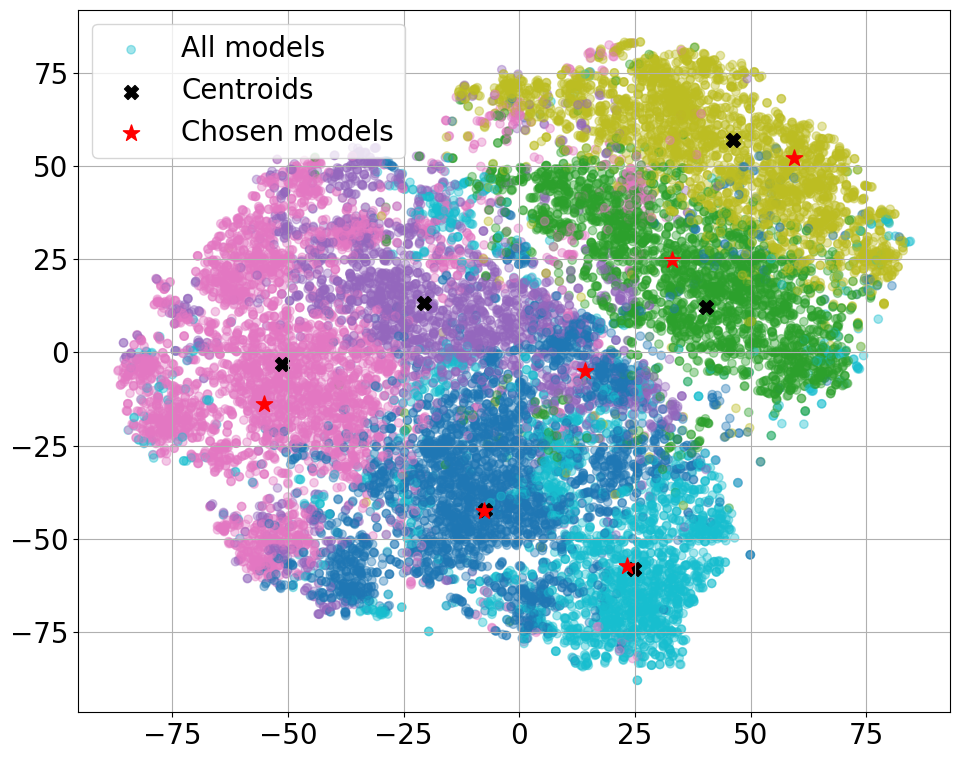

In [18]:
best_models_cluster, best_embeddings_cluster, best_accuracies_cluster = select_central_models_by_clusters(
    potential_archs, potential_embeddings, potential_accuracies, K, random_state=42, plot_tsne=True
)

In [12]:
def save_models_to_dir(best_models, dir_name):
    os.makedirs(dir_name, exist_ok=True)
    
    # Сохраняем архитектуры по одной
    for i, arch in enumerate(best_models, 1):
        file_path = os.path.join(dir_name, f"model_{i:02d}.json")
        with open(file_path, "w") as f:
            json.dump(arch, f, indent=4)
        print(f"Сохранена модель {i} в {file_path}")

In [13]:
save_models_to_dir(best_models_cluster, "best_models_greed_cluster")
save_models_to_dir(best_models_acc, "best_models_greed")

Сохранена модель 1 в best_models_greed_cluster/model_01.json
Сохранена модель 2 в best_models_greed_cluster/model_02.json
Сохранена модель 3 в best_models_greed_cluster/model_03.json
Сохранена модель 4 в best_models_greed_cluster/model_04.json
Сохранена модель 5 в best_models_greed_cluster/model_05.json
Сохранена модель 6 в best_models_greed_cluster/model_06.json
Сохранена модель 1 в best_models_greed/model_01.json
Сохранена модель 2 в best_models_greed/model_02.json
Сохранена модель 3 в best_models_greed/model_03.json
Сохранена модель 4 в best_models_greed/model_04.json
Сохранена модель 5 в best_models_greed/model_05.json
Сохранена модель 6 в best_models_greed/model_06.json


In [14]:
!zip -r best_models best_models_greed
!zip -r best_models best_models_greed_cluster

  adding: best_models_greed/ (stored 0%)
  adding: best_models_greed/model_04.json (deflated 84%)
  adding: best_models_greed/model_02.json (deflated 83%)
  adding: best_models_greed/model_06.json (deflated 84%)
  adding: best_models_greed/model_01.json (deflated 84%)
  adding: best_models_greed/model_05.json (deflated 84%)
  adding: best_models_greed/model_03.json (deflated 85%)
  adding: best_models_greed_cluster/ (stored 0%)
  adding: best_models_greed_cluster/model_04.json (deflated 84%)
  adding: best_models_greed_cluster/model_02.json (deflated 84%)
  adding: best_models_greed_cluster/model_06.json (deflated 84%)
  adding: best_models_greed_cluster/model_01.json (deflated 84%)
  adding: best_models_greed_cluster/model_05.json (deflated 84%)
  adding: best_models_greed_cluster/model_03.json (deflated 84%)
